## Algoritmo: Árbol de decisión

Implementado por: Sergio Ramírez Vélez

### 1. Instalación e importanción de librerías.


In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

In [2]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1

In [3]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Juan
[nltk_data]     Diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Juan
[nltk_data]     Diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Juan
[nltk_data]     Diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier 
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
from sklearn import tree

### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos.

In [7]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t = data

### 3. Preparación de datos

In [8]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [9]:
data_t['study_and_condition'] = data_t['study_and_condition'].apply(contractions.fix) #Aplica la corrección de las contracciones
data_t.head()

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...


In [10]:
data_t['words'] = data_t['study_and_condition'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
data_t.head()

,label,study_and_condition,words
0,__label__0,study interventions are Saracatinib . recurren...,"[study, interventions, saracatinib, recurrent,..."
1,__label__1,study interventions are Stem cell transplantat...,"[study, interventions, stem, cell, transplanta..."
2,__label__0,study interventions are Lenograstim . recurren...,"[study, interventions, lenograstim, recurrent,..."
3,__label__0,study interventions are Doxorubicin . stage ii...,"[study, interventions, doxorubicin, stage, iii..."
4,__label__1,study interventions are Poly I-C . prostate ca...,"[study, interventions, poly, ic, prostate, can..."


In [11]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data_t['words'] = data_t['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t.head()

,label,study_and_condition,words
0,__label__0,study interventions are Saracatinib . recurren...,"[study, interv, saracatinib, recur, verruc, ca..."
1,__label__1,study interventions are Stem cell transplantat...,"[study, interv, stem, cel, transpl, hodgkin, l..."
2,__label__0,study interventions are Lenograstim . recurren...,"[study, interv, lenograstim, recur, adult, dif..."
3,__label__0,study interventions are Doxorubicin . stage ii...,"[study, interv, doxorubicin, stag, ii, diffus,..."
4,__label__1,study interventions are Poly I-C . prostate ca...,"[study, interv, poly, ic, prost, cant, diagnos..."


In [12]:
data_t['words'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,label,study_and_condition,words
0,__label__0,study interventions are Saracatinib . recurren...,study interv saracatinib recur verruc carcinom...
1,__label__1,study interventions are Stem cell transplantat...,study interv stem cel transpl hodgkin lymphom ...
2,__label__0,study interventions are Lenograstim . recurren...,study interv lenograstim recur adult diffus mi...
3,__label__0,study interventions are Doxorubicin . stage ii...,study interv doxorubicin stag ii diffus larg c...
4,__label__1,study interventions are Poly I-C . prostate ca...,study interv poly ic prost cant diagnos unreso...
...,...,...,...
11995,__label__0,study interventions are Prednisolone hemisucci...,study interv prednisolon hemisuccin recur chil...
11996,__label__0,study interventions are Bevacizumab . recurren...,study interv bevacizumab recur rect cant diagn...
11997,__label__1,"study interventions are Antibodies, Monoclonal...",study interv antibody monoclon recur lymphobla...
11998,__label__0,study interventions are Vorinostat . colorecta...,study interv vorinost colorect cant diagnos pa...


In [13]:
X_data, y_data = data_t['words'],data_t['label']
y_data = (y_data == '__label__1').astype(int)
y_data

0        0
1        1
2        0
3        0
4        1
        ..
11995    0
11996    0
11997    1
11998    0
11999    0
Name: label, Length: 12000, dtype: int32

In [14]:
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count)
X_count.toarray()[0]

  (0, 9354)	6
  (0, 5213)	1
  (0, 8787)	2
  (0, 8433)	1
  (0, 10565)	1
  (0, 1474)	1
  (0, 5550)	2
  (0, 2676)	1
  (0, 7393)	1
  (0, 6509)	2
  (0, 349)	1
  (0, 10426)	1
  (0, 255)	1
  (0, 1239)	1
  (0, 2137)	2
  (0, 2931)	1
  (0, 7366)	1
  (0, 5581)	2
  (0, 3061)	2
  (0, 10701)	1
  (0, 2787)	1
  (0, 2911)	2
  (0, 5219)	1
  (0, 8435)	1
  (0, 10566)	1
  :	:
  (11998, 10649)	1
  (11998, 10650)	1
  (11999, 9354)	4
  (11999, 5213)	1
  (11999, 2676)	1
  (11999, 7366)	1
  (11999, 10701)	1
  (11999, 5219)	1
  (11999, 2678)	1
  (11999, 7370)	1
  (11999, 10703)	1
  (11999, 7961)	1
  (11999, 7981)	1
  (11999, 1443)	1
  (11999, 1436)	1
  (11999, 7214)	1
  (11999, 7215)	1
  (11999, 9049)	1
  (11999, 5292)	1
  (11999, 9045)	1
  (11999, 5294)	1
  (11999, 3919)	2
  (11999, 273)	1
  (11999, 274)	1
  (11999, 3950)	2


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
X_data

0        study interv saracatinib recur verruc carcinom...
1        study interv stem cel transpl hodgkin lymphom ...
2        study interv lenograstim recur adult diffus mi...
3        study interv doxorubicin stag ii diffus larg c...
4        study interv poly ic prost cant diagnos unreso...
                               ...                        
11995    study interv prednisolon hemisuccin recur chil...
11996    study interv bevacizumab recur rect cant diagn...
11997    study interv antibody monoclon recur lymphobla...
11998    study interv vorinost colorect cant diagnos pa...
11999    study interv freund adjuv ov cant diagnos four...
Name: words, Length: 12000, dtype: object

In [16]:
# Se realiza el ajuste tf-idf
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(X_data)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
X_tfidf = pd.DataFrame(denselist, columns=feature_names)

print(X_tfidf.shape)
print(X_tfidf)

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(12000, 10842)
        01  01910na  025   05   09  0three_two9  0two_two009  \
0      0.0      0.0  0.0  0.0  0.0          0.0          0.0   
1      0.0      0.0  0.0  0.0  0.0          0.0          0.0   
2      0.0      0.0  0.0  0.0  0.0          0.0          0.0   
3      0.0      0.0  0.0  0.0  0.0          0.0          0.0   
4      0.0      0.0  0.0  0.0  0.0          0.0          0.0   
...    ...      ...  ...  ...  ...          ...          ...   
11995  0.0      0.0  0.0  0.0  0.0          0.0          0.0   
11996  0.0      0.0  0.0  0.0  0.0          0.0          0.0   
11997  0.0      0.0  0.0  0.0  0.0          0.0          0.0   
11998  0.0      0.0  0.0  0.0  0.0          0.0          0.0   
11999  0.0      0.0  0.0  0.0  0.0          0.0          0.0   

       10deazaaminopterin   11   12  ...  zoledron  zoledronate  zoledronic  \
0                     0.0  0.0  0.0  ...       0.0          0.0         0.0   
1                     0.0  0.0  0.0  ...       0.0        

In [17]:
# Se muestra el resultado del ajuste tf-idf
#for name, values in X_tfidf.iteritems():
#    if values[0] > 0: 
#        print('{name}: {value}'.format(name=name, value=values[0]))

## 4. Creación y Aplicación del modelo
Una vez se tiene la representación vectorial de cada uno de los textos, se lleva a cabo la tarea de clasificación, que en este caso será binaria debido al rango de la variable objetivo.

In [18]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X_tfidf, y_data, test_size=0.2, random_state=0)  # Semilla: 0

In [19]:
# Se fija el número de particiones: K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [20]:
# Se establece el espacio de búsqueda de hiperparámetros
#param_grid = {'criterion':['gini', 'entropy'],'max_depth':[10,20,30],'min_samples_split':[2,3]}

# Se seleccionaron los mejores parámetros debido al gran tiempo de ejecución que toma la búsqueda
param_grid = {'criterion':['gini'],'max_depth':[30],'min_samples_split':[2]}

In [21]:
# Se define el modelo
arbol = DecisionTreeClassifier(random_state=0)

In [22]:
# Se utiliza GridSearch sobre el grid definido en la validación cruzada
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Se entrena el modelo
mejor_modelo.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini'], 'max_depth': [30],
                         'min_samples_split': [2]})

In [23]:
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}

In [24]:
arbol_final = mejor_modelo.best_estimator_
y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.85
Exactitud sobre test: 0.72


C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


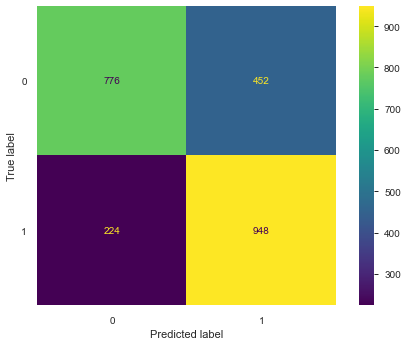

In [25]:
plot_confusion_matrix(arbol_final, X_test, Y_test)  
plt.show()

In [26]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1228
           1       0.68      0.81      0.74      1172

    accuracy                           0.72      2400
   macro avg       0.73      0.72      0.72      2400
weighted avg       0.73      0.72      0.72      2400



In [27]:
importancia = arbol_final.feature_importances_
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

,Atributo,Importancia
0,history,0.052124
1,must,0.047128
2,paty,0.036657
3,tre,0.032977
4,zero,0.023309
...,...,...
10837,feto,0.000000
10838,fetoprotein,0.000000
10839,fetoprotein_afp,0.000000
10840,fetus,0.000000


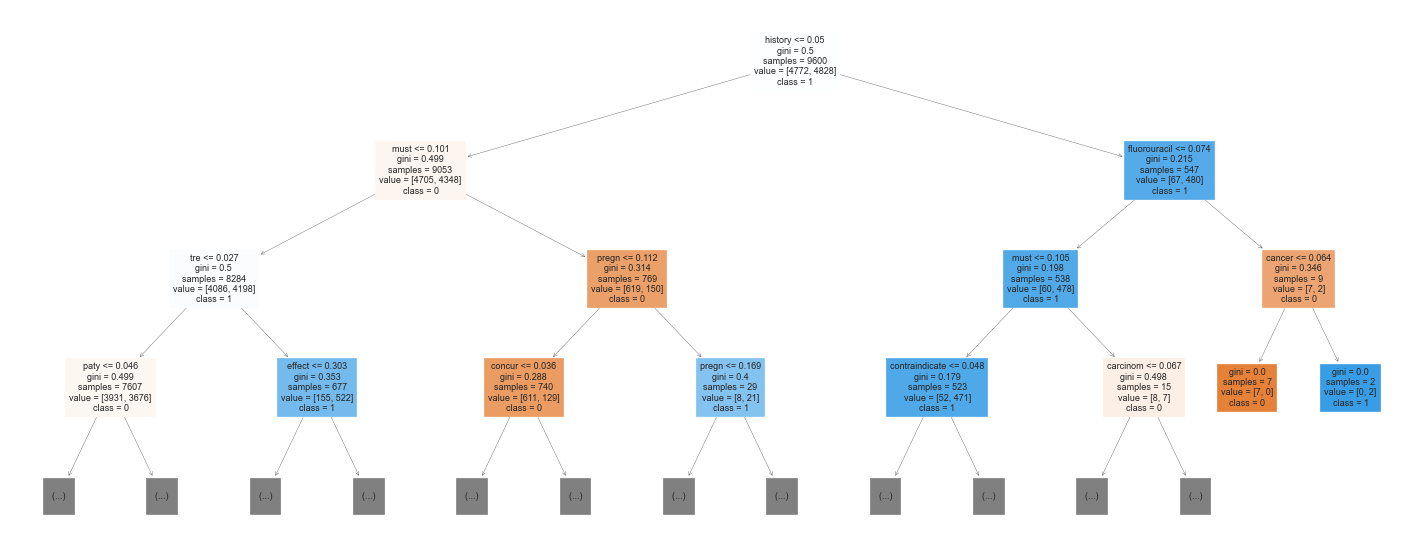

In [28]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol_final, max_depth=3, feature_names=X_tfidf.columns, class_names=["0", "1", "2"], filled=True, fontsize=9)